## Guided Project: Answering Business Questions using SQL

In this project, I practice using SQL to query information for a fictional business named Chinook. First, I will import all the requisite files. Then, I will create helper functions.

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [4]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)        

In [5]:
def show_tables():
    return run_query("SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view')")        

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## In this project, Chinook has hired me to use their data to make business decisions. First, they ask me to decide which albums they should prioritize adding to their store.
#### Chinook has signed a deal with a new record label that specializes in the U.S. The record label has given us four album as well as the artist and genre of each album. I have been tasked with choosing which three Chinook should add to their store first. Because this is a U.S. record label, I want to see which genres are the best selling in the U.S. and choose the albums of the corresponding genres, if possible.

First, I need to checkout the schema provided by DataQuest to see which tables I will need.

In [7]:
from IPython.display import Image
Image(url='https://s3.amazonaws.com/dq-content/191/chinook-schema.svg')


I need the genre table in order to get the genre names. I will also need the invoice_line table to get the number of sales were made for each genre and the invoice table to get the country for each purchase. Since the track table is the only connection between genre and invoice_line_id, I will need that as well.

In [8]:
q = """SELECT g.name genre_name, invoice_line_id, i.billing_country FROM genre g 
        INNER JOIN track t ON t.genre_id=g.genre_id 
        INNER JOIN invoice_line id ON id.track_id = t.track_id 
        INNER JOIN invoice i on i.invoice_id = id.invoice_id 
    WHERE i.billing_country = 'USA'"""
run_query(q)

,genre_name,invoice_line_id,billing_country
0,Rock,1,USA
1,Rock,2,USA
2,Rock,3,USA
3,Rock,4,USA
4,Rock,5,USA
5,Rock,6,USA
6,Rock,7,USA
7,Rock,8,USA
8,Rock,9,USA
9,Rock,10,USA


Now I need to get the count of each invoice_line_id in order to see how many times that genre was sold.

In [9]:
q = """
WITH usa AS
    (
       SELECT g.name genre_name, invoice_line_id, i.billing_country FROM genre g 
        INNER JOIN track t ON t.genre_id=g.genre_id 
        INNER JOIN invoice_line id ON id.track_id = t.track_id 
        INNER JOIN invoice i on i.invoice_id = id.invoice_id 
    WHERE i.billing_country = 'USA'
    )

SELECT
    genre_name,
    COUNT(invoice_line_id) tracks_sold,
    CAST(COUNT(invoice_line_id) as FLOAT)/CAST((SELECT COUNT(1) FROM usa) as FLOAT) percentage
FROM usa   
GROUP BY genre_name
ORDER BY percentage DESC
"""
genre_usa_sales = run_query(q)
genre_usa_sales

,genre_name,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Looks like the best selling genres in the U.S. are Rock, Alternative & Punk, and Metal in that order. 

### Histrogram of the above data:

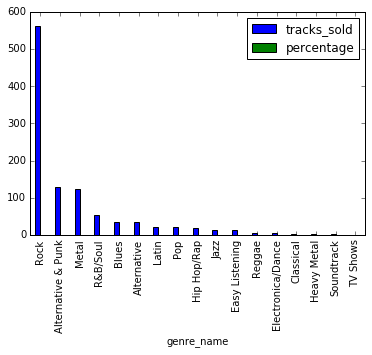

In [10]:
genre_usa_sales.set_index('genre_name').plot.bar()

### Conclusion:
The artists and genres of the albums the record label gave us are:

Regal, Hip-Hop | Red Tone, Punk | Meteor and the Girls, Pop | Slim Jim Bites, Blues

I recommend adding the albums by Red Tone, Slim Jim Bites, and Meteor and the Girls first.

## Chinook has now asked me to evaluate their employees using sales data to see if there are any over- or under-performers in their store.

To do this, I will look into how much money each sales support agent has under their name. First, I will get the relevant columns from the data.

In [11]:
q = """
    SELECT
        e.first_name || ' ' || e.last_name AS name,
        e.hire_date,        
        e.title,
        e.country,
        SUM(i.total) total_sales
    FROM employee e
    INNER JOIN customer c ON e.employee_id = c.support_rep_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id    
    GROUP BY name
"""
run_query(q)

,name,hire_date,title,country,total_sales
0,Jane Peacock,2017-04-01 00:00:00,Sales Support Agent,Canada,1731.51
1,Margaret Park,2017-05-03 00:00:00,Sales Support Agent,Canada,1584.00
2,Steve Johnson,2017-10-17 00:00:00,Sales Support Agent,Canada,1393.92



There's no strong evidence of anyone over- or under-performing. While Steve Johnson does have a lower total_sales number, he was also hired 5-6 months after the other Sales Support Agents. Futhermore, each of these employees are making their sales in different countries which could be a mitigating factor.

## The next task is to calculate the total number of customers, total value of sales, average values of sales per customer, and average order value for each country.

First, to make things easier for myself, I'm going to create a view with the data I want.

In [12]:
q = """
WITH country_data AS    
    (
        SELECT            
            CASE
                WHEN 
                    (SELECT COUNT(DISTINCT c2.customer_id)
                    FROM customer c2
                    WHERE c2.country = c.country)=1
                THEN 'Other'
                ELSE c.country
            END AS country,
            c.customer_id,
            i.total
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id        
    )

SELECT
    country,
    customers,
    total_sales,
    avg_cust,
    avg_order
FROM
    (SELECT 
        country,
        COUNT (DISTINCT customer_id) customers,
        SUM(total) total_sales,
        SUM(total) / COUNT (DISTINCT customer_id) avg_cust,
        SUM(total) / COUNT(total) avg_order,
        CASE 
            WHEN
                country = 'Other' THEN 1
                ELSE 0
            END AS sort
    FROM country_data
    GROUP BY country)
ORDER BY sort, total_sales DESC

    
"""
run_query(q)

,country,customers,total_sales,avg_cust,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


Now I need to create visualizations to communicate the findings with stakeholders.

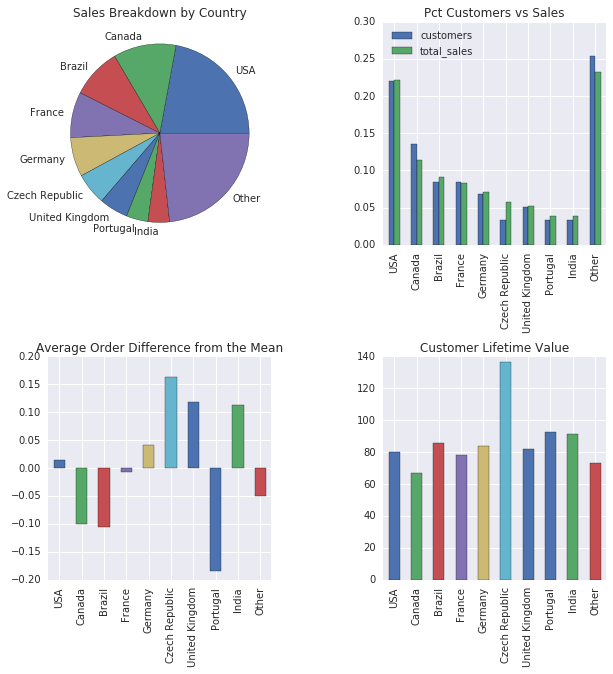

In [13]:
import seaborn as sns
metrics = run_query(q)
metrics.set_index('country', inplace=True)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax1, ax2, ax3, ax4 = ax.flatten()
fig.subplots_adjust(hspace=.5, wspace=.5)


#Sales Breakdown
sales_breakdown = metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,    
    title='Sales Breakdown by Country')

#Customers vs. Sales
cust_sales = metrics[['customers','total_sales']].copy()
cust_sales.index.name=''
cust_sales['customers'] = cust_sales['customers']/cust_sales['customers'].sum()
cust_sales['total_sales'] = cust_sales['total_sales']/cust_sales['total_sales'].sum()
cust_sales.plot.bar(
        ax=ax2,
        title="Pct Customers vs Sales"    
        )

#Avg order pct difference from the mean
order_data = metrics['avg_order']
order_mean = metrics['avg_order'].mean()
diff_from_avg = (order_data / order_mean) - 1
diff_from_avg.index.name = ''
diff_from_avg.plot.bar(
    ax=ax3,
    title='Average Order Difference from the Mean')

#Total Sales per Customer
sales_per_cust = metrics['avg_cust'].copy()
sales_per_cust.plot.bar(ax=ax4, title='Customer Lifetime Value')

The Czech Republic, the United Kingdom, and and India all have high average order purchases compared to the mean; however, they do not have a good amount of customers.

The next question is whether or not Chinook should purchase individual tracks from record companies instead of full albums. To decide this, I will look at what percentage of purchase are full albums.

In [278]:
q = """
WITH first_track AS
(
    SELECT
        t.track_id,
        a.album_id,
        i.invoice_id
    FROM track t
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id 
    GROUP BY i.invoice_id
)



SELECT
    is_album,
    COUNT(is_album),
    CAST(COUNT(is_album) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent    
FROM
(SELECT 
    CASE WHEN
            (SELECT
                il2.track_id
            FROM invoice_line il2
            WHERE il2.invoice_id = ft.invoice_id
            EXCEPT 
            SELECT
                t.track_id
            FROM track t            
            WHERE t.album_id = ft.album_id) IS NULL 
        AND
            (SELECT
                t.track_id
            FROM track t            
            WHERE t.album_id = ft.album_id
            EXCEPT
            SELECT
                il2.track_id
            FROM invoice_line il2
            WHERE ft.invoice_id = il2.invoice_id) IS NULL         
        THEN 'yes'
        ELSE 'no'
    END AS is_album
FROM first_track ft)
GROUP BY is_album        

    
"""
run_query(q)

,is_album,COUNT(is_album),percent
0,no,500,0.814332
1,yes,114,0.185668


## Conclusion:

Since about 19% of invoices include full album purchases, I would recommend that Chinook continue buying full albums from record companies.